In [2]:
import pandas as pd

In [3]:
dataset = pd.read_csv('./retain/decision_datav1_20241128-225032_6fe0f1e9_62900.csv',
                    names=['x', 'y', 'v_x', 'v_y', 'angle', 'ang_vel', 'leg1', 'leg2', 'action'])
# clean up data. remove 90% of samples that have leg1 or leg2 == 1

dataset = dataset[(dataset['leg1'] == 0.0) | (dataset['leg2'] == 0.0)]


dataset

,x,y,v_x,v_y,angle,ang_vel,leg1,leg2,action
0,0.00,1.42,0.23,0.32,-0.00,-0.05,0.0,0.0,1
1,0.00,1.42,0.22,0.29,-0.00,-0.00,0.0,0.0,1
2,0.01,1.43,0.21,0.27,-0.00,0.03,0.0,0.0,1
3,0.01,1.44,0.20,0.24,0.00,0.08,0.0,0.0,1
4,0.01,1.44,0.19,0.22,0.01,0.11,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...
14995,-0.18,-0.01,0.12,-0.03,0.08,-0.08,0.0,0.0,2
14996,-0.18,-0.01,0.12,-0.02,0.08,-0.08,0.0,0.0,2
14997,-0.18,-0.01,0.11,0.02,0.07,-0.08,0.0,0.0,3
14998,-0.18,-0.01,0.12,-0.00,0.07,-0.12,0.0,0.0,1


0.9118369706605001


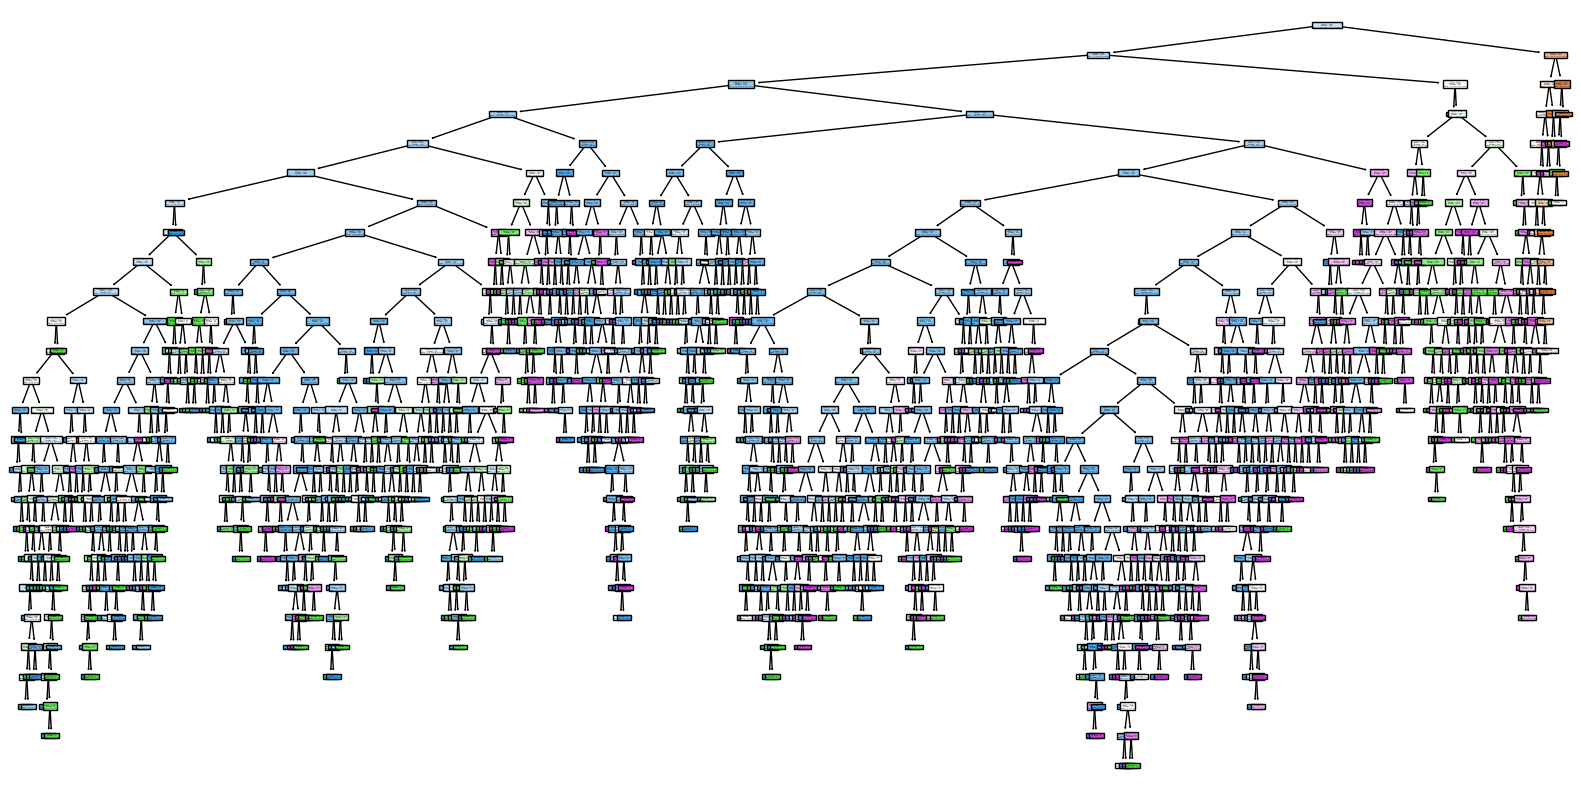

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt

X = dataset.drop('action', axis=1)
y = dataset['action']

clf = DecisionTreeClassifier(
    criterion='entropy',
    random_state=0,
    max_leaf_nodes=1000,
)
clf.fit(X, y)

print(clf.score(X, y))

plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=X.columns)
plt.show()

In [6]:
# tune by grid search
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'criterion': ['entropy'],
    'max_depth': range(2, 10, 1),
    'max_leaf_nodes': range(1, 20),
    'min_samples_leaf': range(1, 500),
}

clf = DecisionTreeClassifier(random_state=0)
grid_search = RandomizedSearchCV(clf, param_grid, cv=2,  n_jobs=-1, verbose=2, n_iter=5000)


grid_search.fit(X, y)

Fitting 2 folds for each of 5000 candidates, totalling 10000 fits


c:\Users\Maciej\miniconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
486 fits failed out of a total of 10000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
486 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Maciej\miniconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Maciej\miniconda3\envs\pytorch\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Maciej\miniconda3\envs\pytorch\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter

RandomizedSearchCV(cv=2, estimator=DecisionTreeClassifier(random_state=0),
                   n_iter=5000, n_jobs=-1,
                   param_distributions={'criterion': ['entropy'],
                                        'max_depth': range(2, 10),
                                        'max_leaf_nodes': range(1, 20),
                                        'min_samples_leaf': range(1, 500)},
                   verbose=2)

<Axes: >

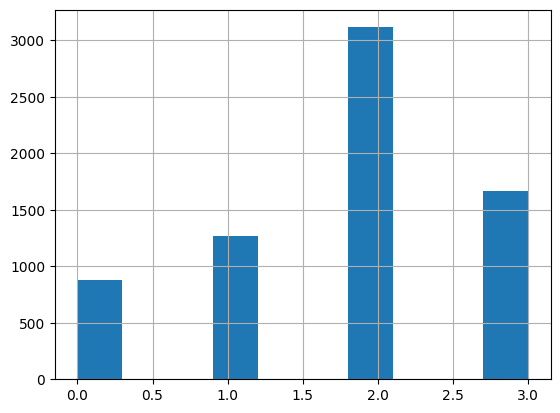

In [7]:
# histogram of actions
dataset['action'].hist()

In [8]:
print(grid_search.best_params_)

{'min_samples_leaf': 16, 'max_leaf_nodes': 17, 'max_depth': 6, 'criterion': 'entropy'}


In [9]:
best_clf = DecisionTreeClassifier(**grid_search.best_params_)

best_clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=6, max_leaf_nodes=17,
                       min_samples_leaf=16)

In [10]:
print(best_clf.score(X, y))

0.6762537939008527


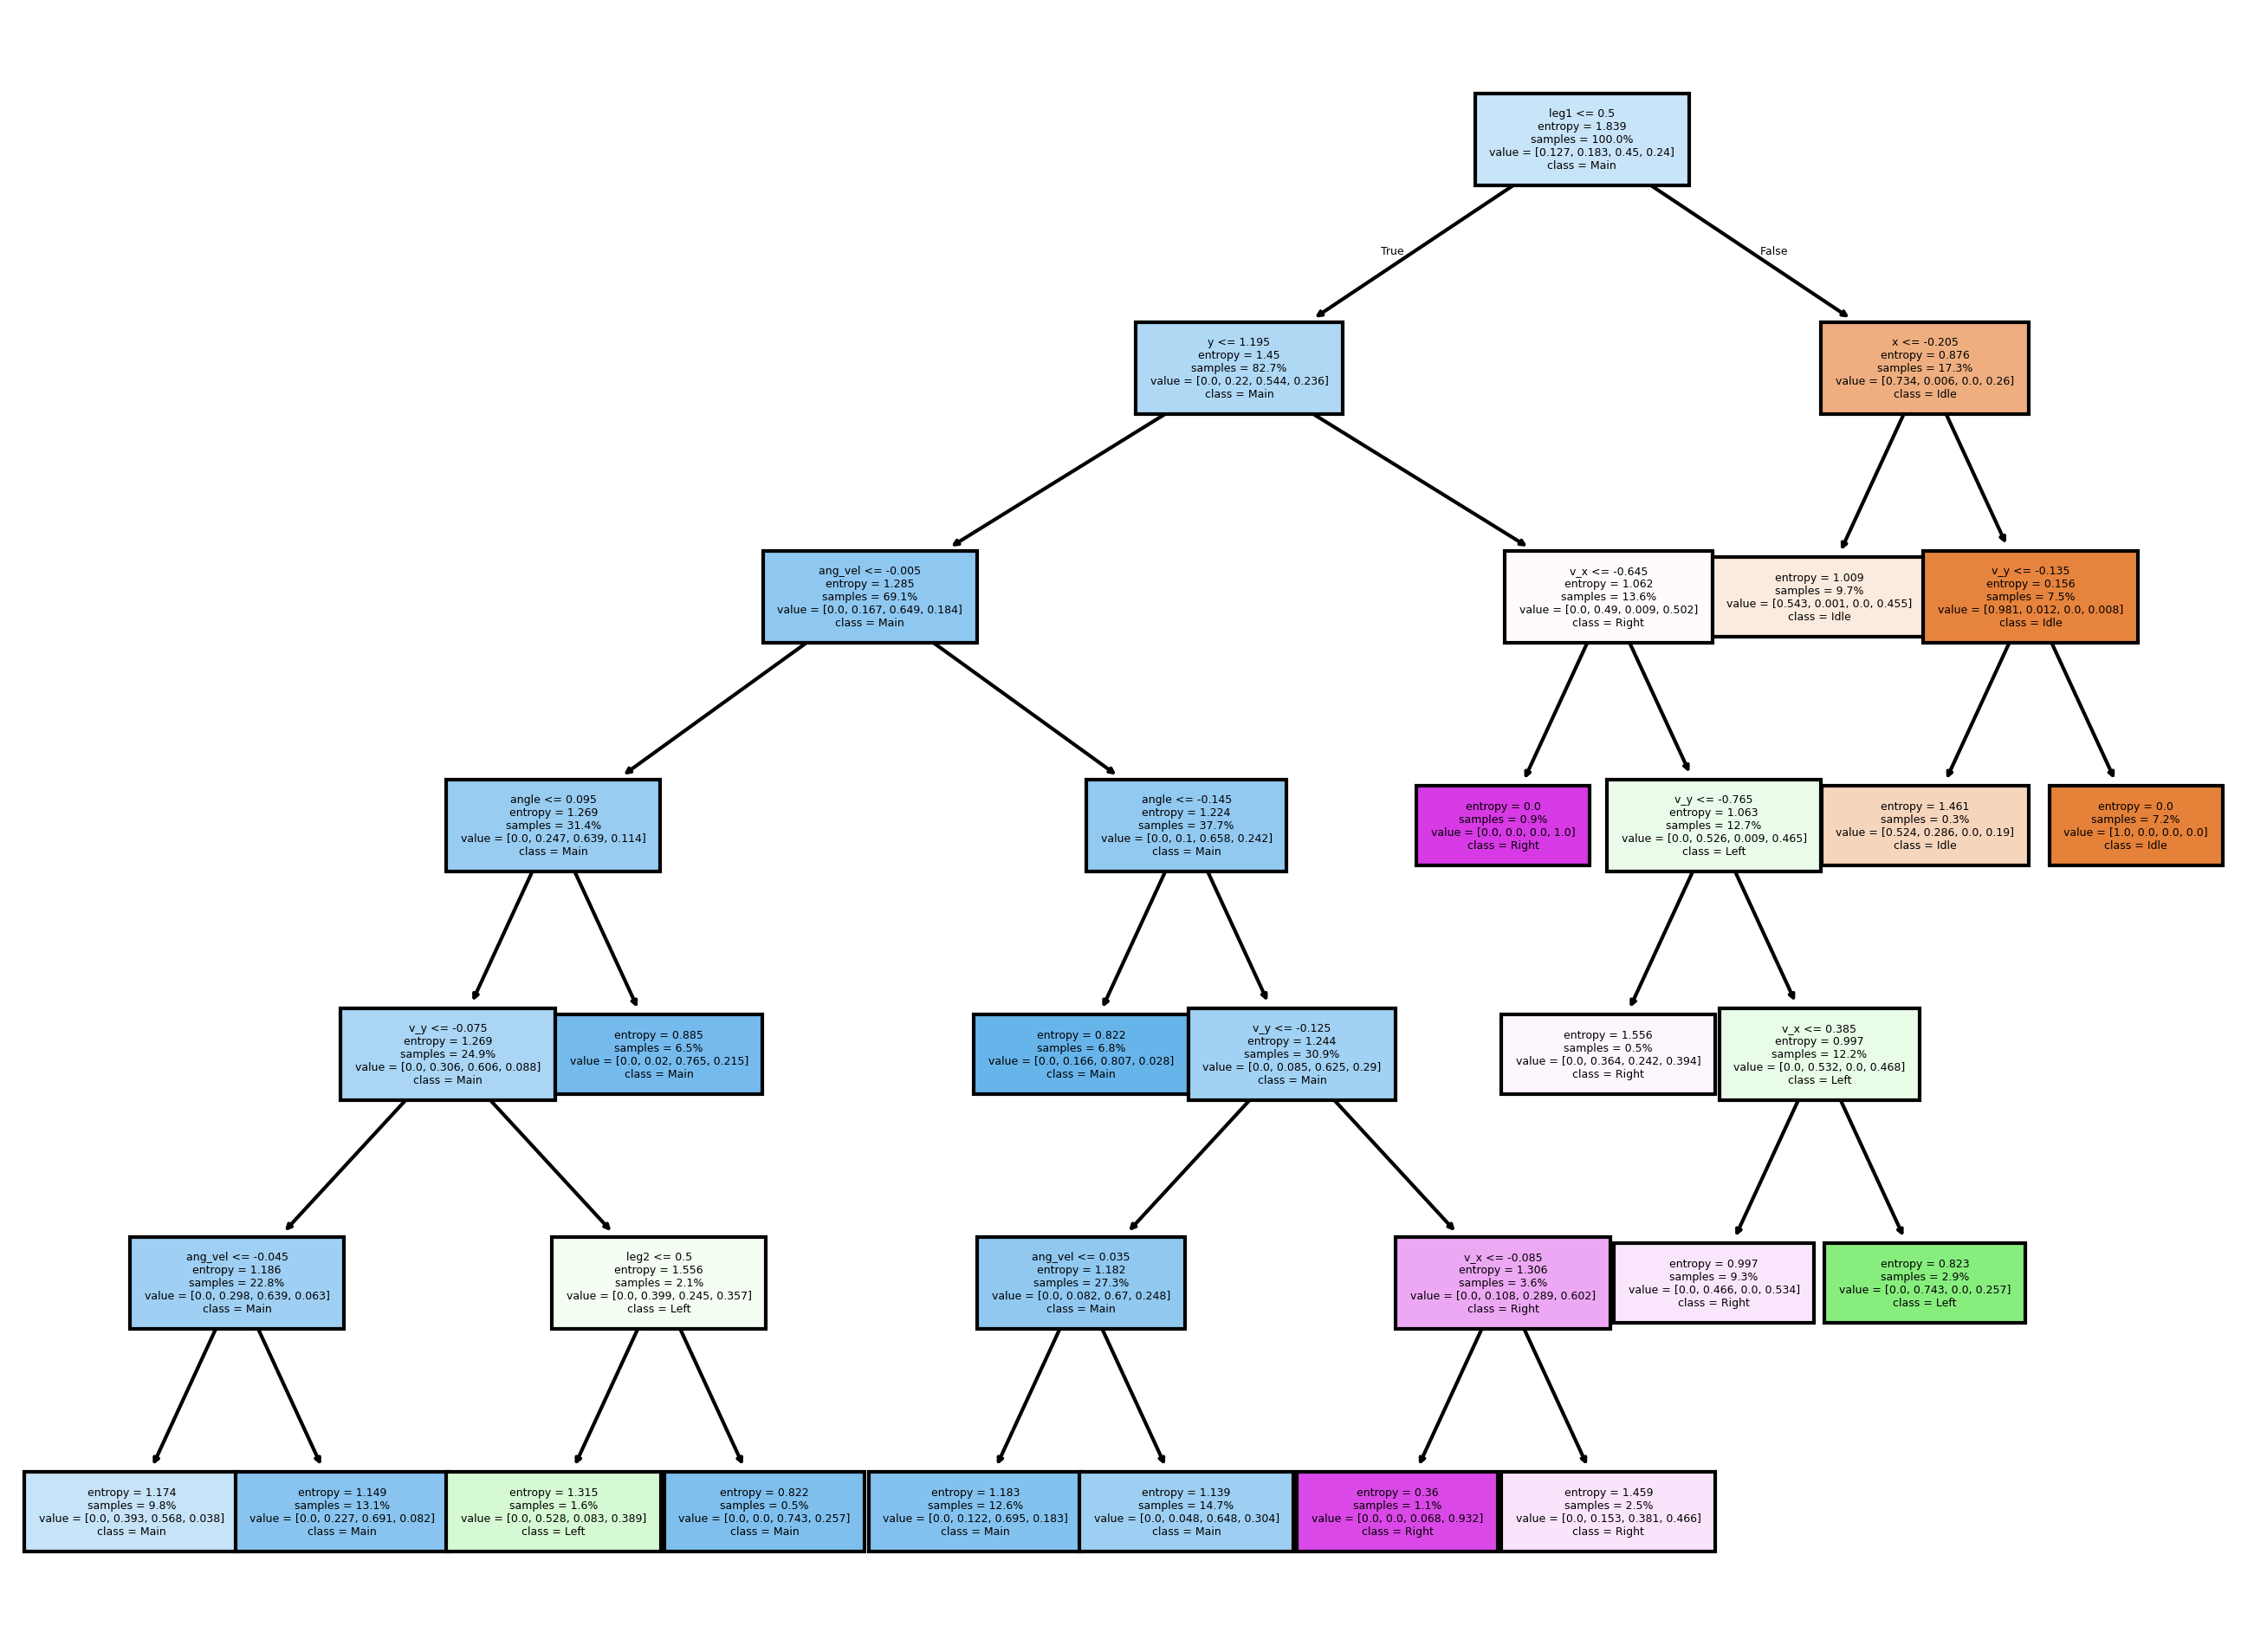

In [13]:
plt.figure(figsize=(11, 8), dpi=300)
# lunar lander has 4 actions
plot_tree(best_clf, filled=True, feature_names=X.columns, class_names=[
    "Idle", "Left", "Main", "Right"
], 
proportion=True,
fontsize=3)
plt.show()

In [23]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=500,
    random_state=0,
    n_jobs=-1,
    max_leaf_nodes=700,
)

clf.fit(X, y)

print(clf.score(X, y))


0.9002746061569591


[[ 0.10845186  0.91723813 -0.04627337 -0.37317019 -0.07425818 -0.00096187]
 [ 0.24217899  0.04334153  0.80858476 -0.02085439  0.48715207  0.21888235]]


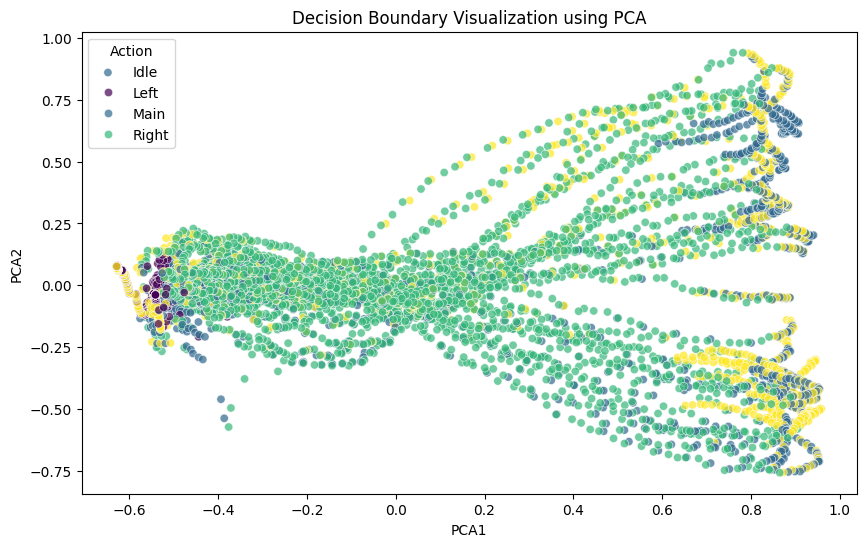

In [46]:
# use PCA 
from sklearn.decomposition import PCA
import seaborn as sns
# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X[['x', 'y', 'v_x', 'v_y', 'angle', 'ang_vel']])

# Create a new DataFrame with the PCA components
df_pca = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
df_pca['action'] = y.values

# Plot the decision boundary
plt.figure(figsize=(10, 6))
# 3d scatter plot of PCA using plt
sns.scatterplot(x='PCA1', y='PCA2', data=df_pca, hue='action', palette='viridis', alpha=0.7)
plt.title('Decision Boundary Visualization using PCA')
plt.legend(title='Action', labels=['Idle', 'Left', 'Main', 'Right'])

print(pca.components_)